# Exploring the OSM Network in Christchurch

In this notebook, I will investigate the viability of using OSM data for the final report. This will include a network analysis and highlightin amenities in Christchurch.

In [452]:
# Importing the necessary libraries
import osmnx as ox
import networkx as nx
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

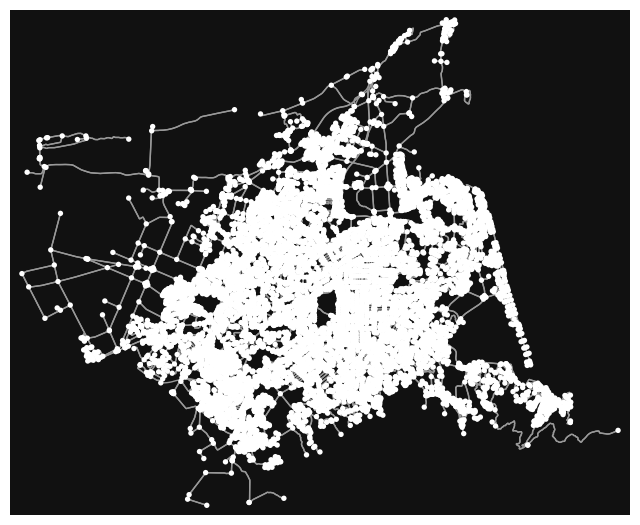

In [453]:
# Christchurch Network
place_name = "Christchurch, New Zealand"

graph = ox.graph_from_place(place_name, network_type='drive')
fig, ax = ox.plot_graph(graph)

In [454]:
# Converting the edges of the graph to a Geodataframe
edges = ox.graph_to_gdfs(graph, nodes=False, edges=True)

<Axes: >

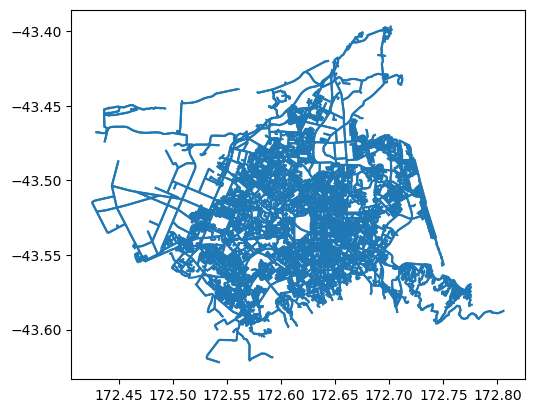

In [455]:
edges.plot()

The goal is to produce network distance analysis rasters for:
- schools (education)
- hospitals (healthcare)
- supermarkets (food sources)

Each of these amenities are necessary for a city to be well functioning and considered liveable. The more of the population that is located close to these amenities, the better. 

In [456]:
# Locating all of the schools in Christchurch City
schools_chc = ox.features_from_place(place_name, tags={'amenity':'school'})

# Locating all of the hospitals in Christchurch City
hospitals_chc = ox.features_from_place(place_name, tags={'amenity':'hospital'})

# Locating all of the supermarkets in Christchurch City
supermarkets_chc = ox.features_from_place(place_name, tags={'shop':'supermarket'})

<Axes: >

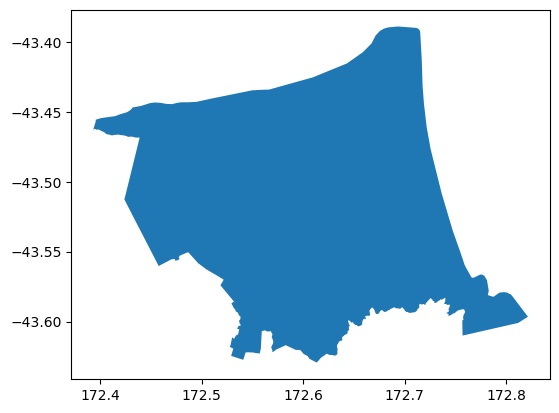

In [457]:
area = ox.geocode_to_gdf(place_name)
area.plot()

### Amenity Map

/tmp/ipykernel_1534100/247775336.py:21: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


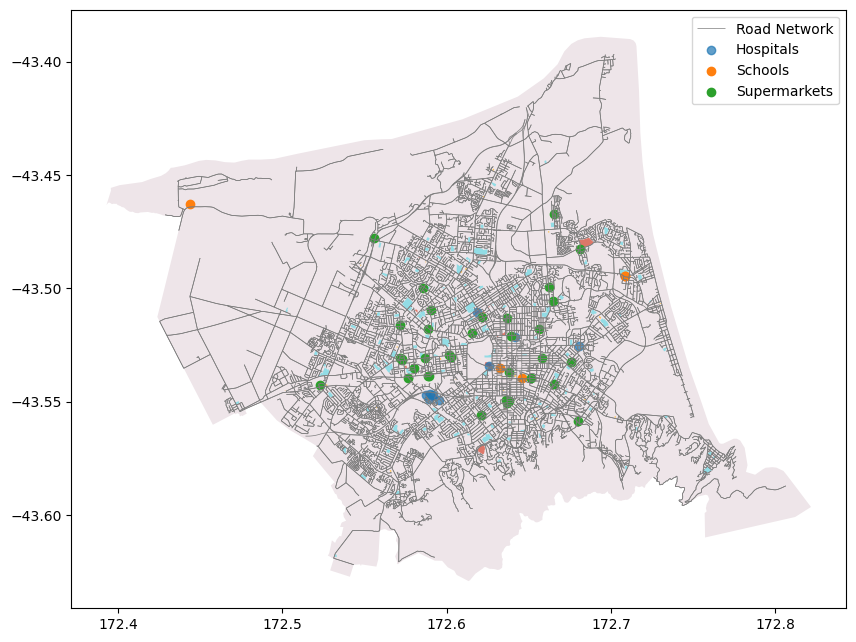

In [458]:
# Visualise in a single figure all the OSM data that was foud:
# Create a figure and an axis for plotting, and set the figure size
fig, ax = plt.subplots(figsize=(10, 10))

# Plot each of the GeoDataFrames on the plotting axis to ensure they are all on the same figure
# Plot the 'area' GeoDataFrame with black face color
area.plot(ax=ax, facecolor="#EEE5E9")

# edges geodataframe
edges.plot(ax=ax, linewidth=0.5, edgecolor="#7C7C7C", label='Road Network')

# hospitals geodataframe
hospitals_chc.plot(ax=ax, facecolor="#D64933", alpha=0.7, label='Hospitals')

# Schools geodataframe
schools_chc.plot(ax=ax, facecolor="#92DCE5", label='Schools')

# supermarkets geodataframe
supermarkets_chc.plot(ax=ax, facecolor='#FFBF46', label='Supermarkets')

ax.legend()



## Inspecting the CRS

In [459]:
# First, chck the CRS of the data
hospitals_chc.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

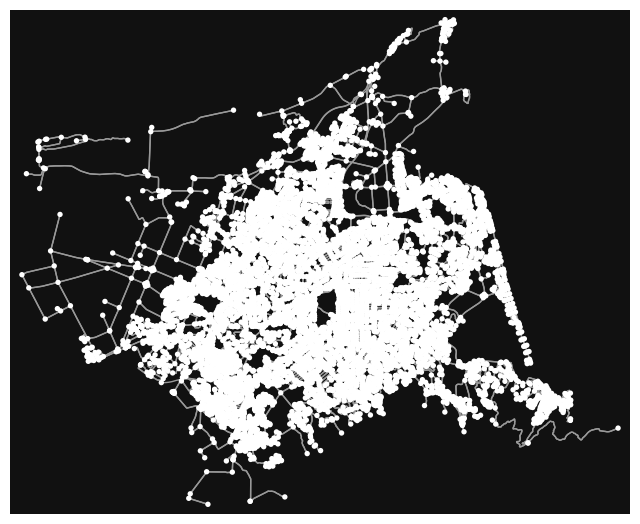

<Figure size 640x480 with 0 Axes>

In [460]:
# Ensuring the crs in epsg:2193 (NZGD2000)
graph_proj = ox.project_graph(graph, to_crs=2193)
fig, ax = ox.plot_graph(graph_proj)
plt.tight_layout()


In [461]:
nodes_proj, edges_proj = ox.graph_to_gdfs(graph_proj, nodes=True, edges=True)
print("Coordinate system:", edges_proj.crs)

Coordinate system: EPSG:2193


In [462]:
# Reprojecting the Amenities

# Schools:
schools_proj = schools_chc.to_crs('EPSG:2193')

# Hospitals:
hospitals_proj = hospitals_chc.to_crs('EPSG:2193')

# Supermarkets:
supermarkets_proj = supermarkets_chc.to_crs('EPSG:2193')

## Network Distance Analysis: Schools

We will start with schools for the first network analysis. The method I am using follows this link: https://automating-gis-processes.github.io/2017/lessons/L7/network-analysis.html, and this link: https://max-coding.medium.com/osmnx-part-2-creating-driving-time-heatmap-718b3e59b81

In [463]:
# Inspecting the columns in the road network
edges.columns

Index(['osmid', 'oneway', 'lanes', 'name', 'highway', 'reversed', 'length',
       'geometry', 'maxspeed', 'junction', 'ref', 'bridge', 'access', 'width',
       'tunnel'],
      dtype='object')

In [464]:
# Highway counts. This is interesting as highways provide good accessibility cross town, but reduce the liveability feel of their proximal environment
edges['highway'].value_counts()

highway
residential                      14199
secondary                         4149
tertiary                          2961
unclassified                      1521
primary                            806
living_street                      722
trunk                              521
trunk_link                         113
[residential, living_street]        96
secondary_link                      84
primary_link                        81
motorway_link                       42
motorway                            38
[residential, unclassified]         14
tertiary_link                       13
busway                               9
[tertiary, unclassified]             2
road                                 2
[secondary_link, residential]        1
Name: count, dtype: int64

In [465]:
# Speed
maxspeed = edges['maxspeed'].value_counts()
maxspeed = maxspeed.to_frame()
maxspeed['Percentage of total'] = maxspeed['count'].apply(lambda x: 100 * x / maxspeed['count'].sum())
maxspeed.head()

count  Percentage of total
maxspeed                            
50        18554            78.695339
40         2629            11.150698
60          888             3.766382
30          578             2.451542
80          234             0.992493

Most roads appear to have a speed limit of 50 km.

In [466]:
# Importing more required libraries
from io import BytesIO
from urllib.request import urlopen
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import contextily as ctx

In [467]:
# adding travel time based on maximum speed
graph_proj = ox.add_edge_speeds(graph_proj) 
graph_proj = ox.add_edge_travel_times(graph_proj) 

In [468]:
# get edges as a geodataframe
_, gdf_edges = ox.graph_to_gdfs(graph_proj)

In [469]:
gdf_edges.length

u            v            key
25365440     38436205     0       53.003742
             25365447     0       30.011345
38436205     25365447     0       45.534676
             2682886711   0      326.977836
25365447     901606056    0        6.133911
                                    ...    
10914784368  6874392985   0      184.723872
11045476184  11045476188  0       17.357002
11045476188  11045476184  0       17.357002
             11045476189  0      138.782398
                          1      187.355058
Length: 25374, dtype: float64

<Axes: title={'center': 'Roads in Christchurch with maximum speed more than 50 km/h'}>

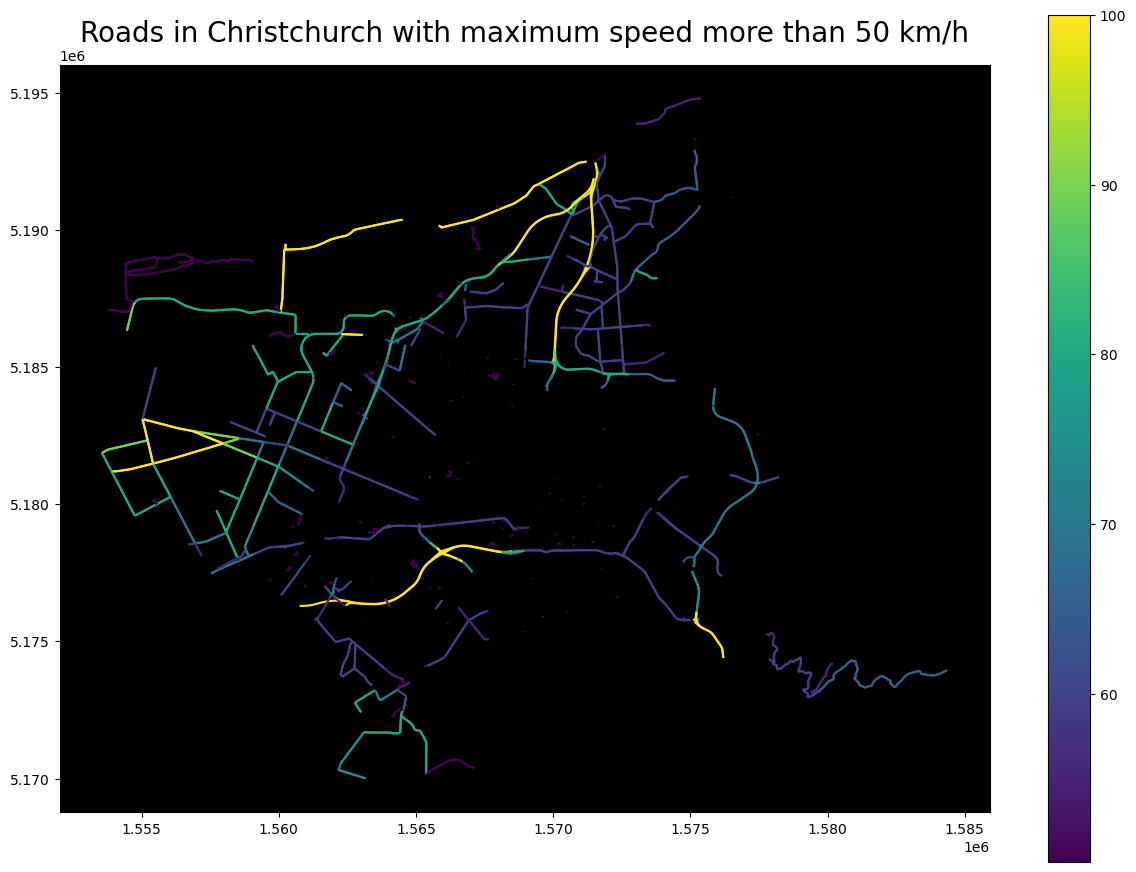

In [470]:
# plotting a road speed graph
fig = plt.figure(figsize=(15,11))
ax = plt.axes()

# Roads higher than 50km
ax.set(facecolor = "black")
ax.set_title("Roads in Christchurch with maximum speed more than 50 km/h", fontsize=20)
gdf_edges[gdf_edges.speed_kph > 50].plot(ax=ax, cmap="viridis", column="speed_kph", legend=True)

<Axes: title={'center': 'Roads in Christchurch with maximum speed more than 30 km/h'}>

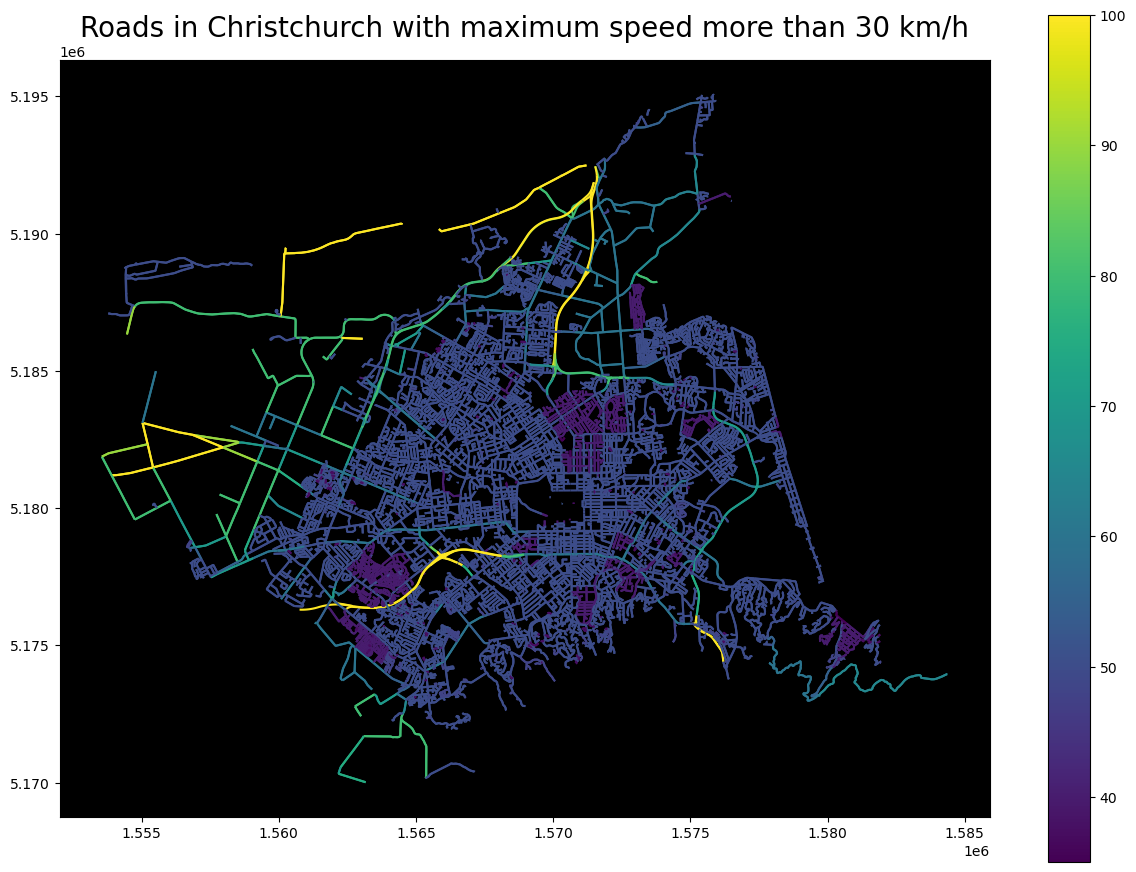

In [471]:
# plotting a road speed graph
fig = plt.figure(figsize=(15,11))
ax = plt.axes()

# Roads higher than 30km
ax.set(facecolor = "black")
ax.set_title("Roads in Christchurch with maximum speed more than 30 km/h", fontsize=20)
gdf_edges[gdf_edges.speed_kph > 30].plot(ax=ax, cmap="viridis", column="speed_kph", legend=True)

### Ilam School

Now that we know the road speed, we can calculate the travel times for the schools.I'll start with Ilam School as a reference point.

In [472]:
# locating Ilam school in the schools geodataframe
ilam_school = schools_proj.loc[schools_proj['name'] == 'Ilam School']

# inspecting geometry
ilam_school.geometry

element_type  osmid   
way           34364215    POLYGON ((1566197.670 5180641.457, 1566030.600...
Name: geometry, dtype: geometry

As the school is a polygon, I will derive a centroid which can be used to locat the nearest node on the road network.

In [473]:
ilam_centre = ilam_school.centroid


In [474]:
# Finding the node closest to the school

# find origin network node
origin_coordinates = ilam_school.geometry
origin_node_id = ox.distance.nearest_nodes(graph_proj, ilam_centre.x[0], ilam_centre.y[0])

In [475]:
# find travel times and route to each node in network
(travel_times, routes) = nx.single_source_dijkstra(graph_proj, origin_node_id, weight="travel_time")

# set travel_time in minutes as attribute to each network node
for node_id in travel_times:
    graph_proj.nodes.get(node_id)["travel_time"] = travel_times[node_id]/60
    
# get nodes and edges as Geo data frame
gdf_nodes, gdf_edges = ox.graph_to_gdfs(graph_proj)

# find longest travel time 
max_time_sec = max(travel_times.values())/60

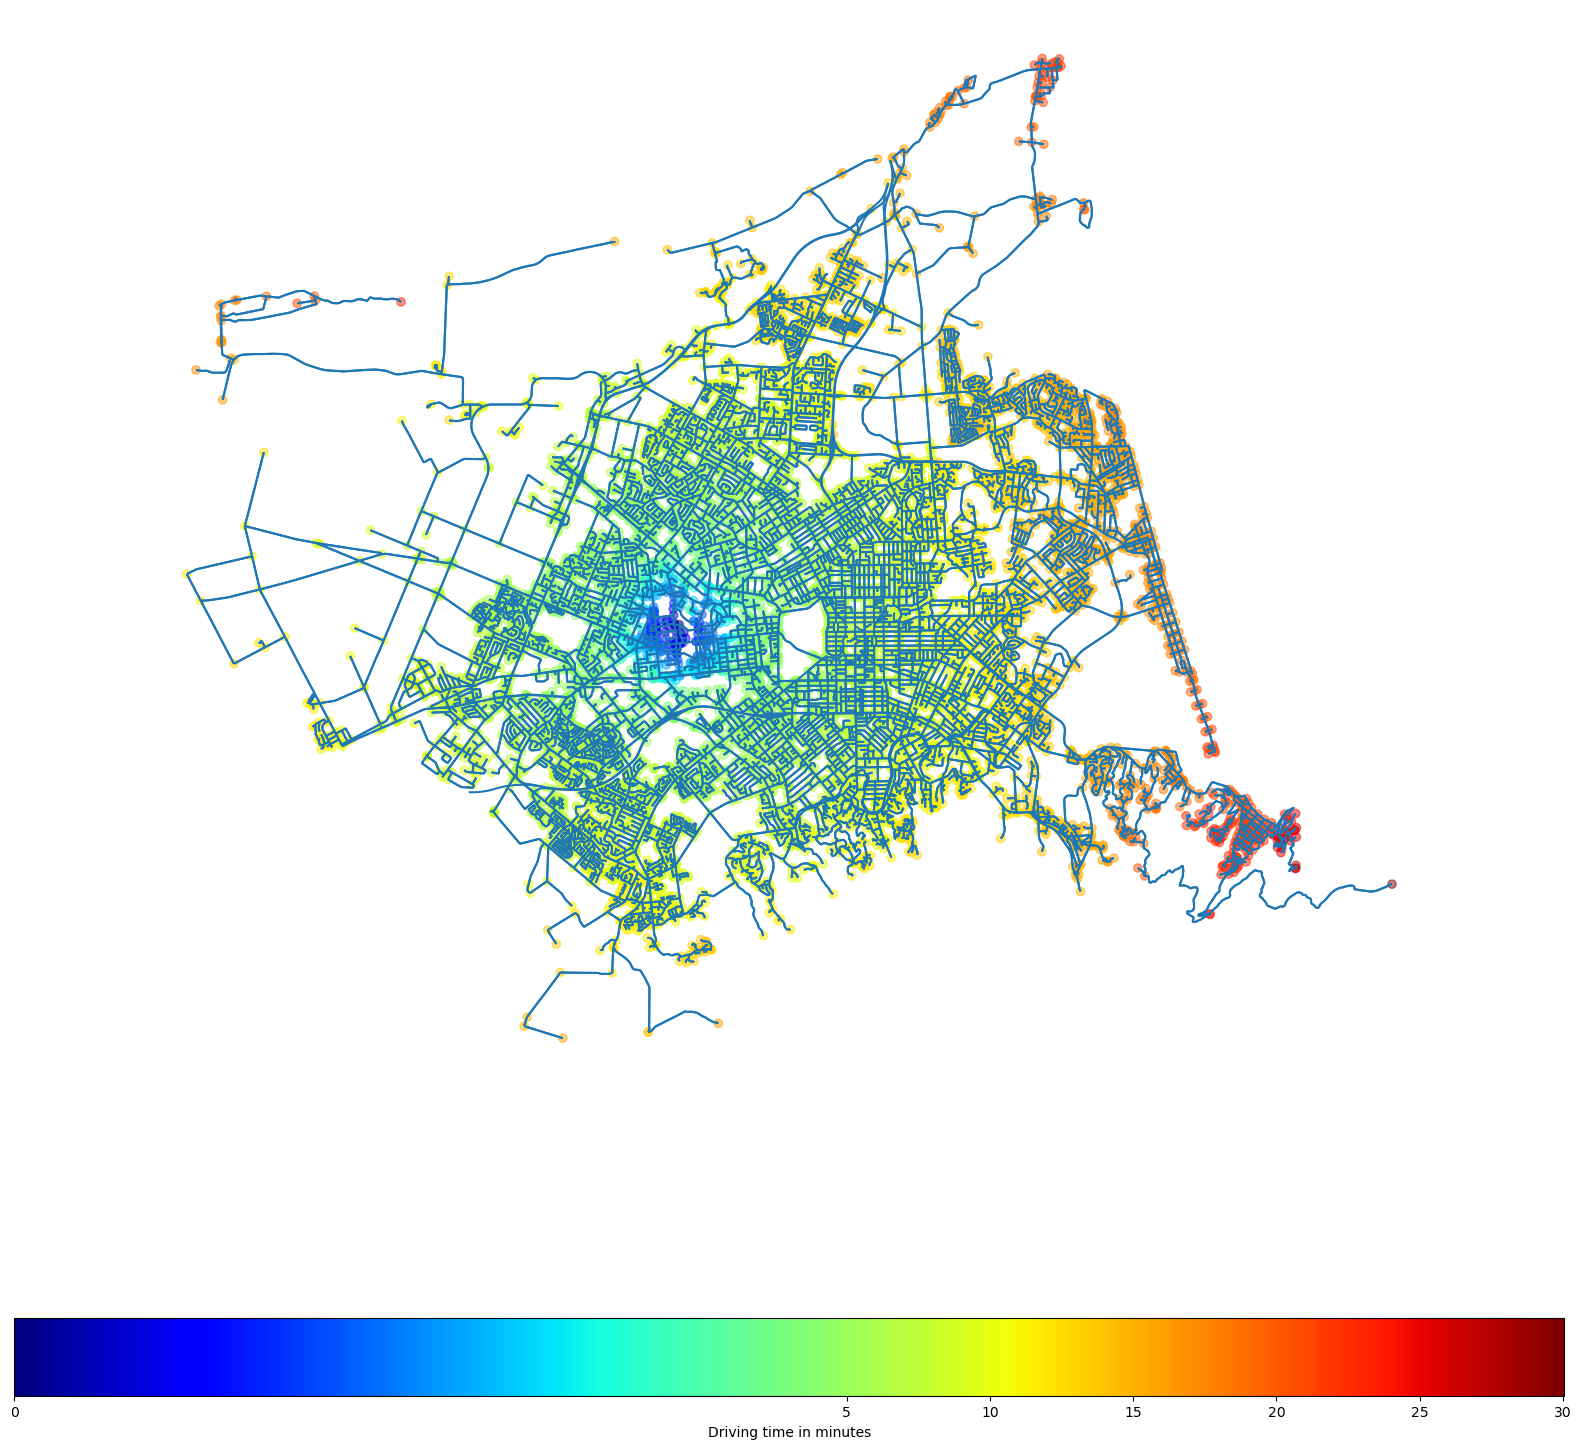

In [476]:
# Creating a heatmap of travel times

# define color scale using minimum and maximum travel times
norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=max_time_sec/10, vmax=max_time_sec)

fig = plt.figure(figsize=(20,20))
ax = plt.axes()
# hide x and y axis
ax.set_axis_off()

# add colotbat showing travel time and corresponding colour
cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap="jet"), 
    ax=ax, orientation='horizontal')

# plot each node with color indicating travel time
gdf_nodes.plot(ax=ax, 
    column="travel_time", cmap="jet", norm=norm, alpha=.5)

gdf_edges.plot(ax=ax)
cb.set_label('Driving time in minutes', fontsize = 10)

### All Schools

Now, driving times must be defined for each school.

In [477]:
# adding x and y values to the geodataframe
schools_proj['x'] = schools_proj.geometry.centroid.x

schools_proj['y'] = schools_proj.geometry.centroid.y

In [478]:
schools_proj.head(3)

geometry amenity  \
element_type osmid                                                 
node         2746776461  POINT (1570324.701 5179692.568)  school   
             5474391444  POINT (1555022.505 5187631.580)  school   
             5474401279  POINT (1571401.623 5179197.152)  school   

                                                    name     addr:city  \
element_type osmid                                                       
node         2746776461  Southern Regional Health School           NaN   
             5474391444           National Trade Academy  Christchurch   
             5474401279                   Marian College  Christchurch   

                                 addr:street addr:country addr:housenumber  \
element_type osmid                                                           
node         2746776461                  NaN          NaN              NaN   
             5474391444  Mcleans Island Road          NaN              NaN   
             5474401279     Barbadoes Street           NZ              122   

                        addr:postcode denomination   religion  ...  \
element_type osmid                                             ...   
node         2746776461           NaN          NaN        NaN  ...   
             5474391444           NaN          NaN        NaN  ...   
             5474401279          8011     catholic  christian  ...   

                        internet_access opening_hours accessibility parking  \
element_type osmid                                                            
node         2746776461             NaN           NaN           NaN     NaN   
             5474391444             NaN           NaN           NaN     NaN   
             5474401279             NaN           NaN           NaN     NaN   

                        roof_pitch building addr:housename check_date  \
element_type osmid                                                      
node         2746776461        NaN      NaN            NaN        NaN   
             5474391444        NaN      NaN            NaN        NaN   
             5474401279        NaN      NaN            NaN        NaN   

                                    x             y  
element_type osmid                                   
node         2746776461  1.570325e+06  5.179693e+06  
             5474391444  1.555023e+06  5.187632e+06  
             5474401279  1.571402e+06  5.179197e+06  

[3 rows x 50 columns]

In [479]:
# finding the list of network nodes closest to each school
school_node_ids = ox.distance.nearest_nodes(graph_proj, schools_proj['x'], schools_proj['y'])

In [480]:
# ensuring all data is accounted for
len(school_node_ids) == len(schools_proj)

True

In [528]:
# Finding travel times for each node and school
schools, routes = nx.multi_source_dijkstra(graph_proj, school_node_ids, weight='travel_time')

# set travel_time in minutes as attribute to each network node
for node_id in schools:
    graph_proj.nodes.get(node_id)["travel_time"] = schools[node_id]/60

# get nodes and edges as Geo data frame
gdf_nodes_schools, gdf_edges_schools = ox.graph_to_gdfs(graph_proj)

# find longest travel time 
max_time_sec = max(travel_times.values())/60

In [529]:
gdf_nodes_schools.head()

y             x  street_count         lon        lat  \
osmid                                                                        
25365440   5.184738e+06  1.563152e+06             3  172.544295 -43.489374   
38436205   5.184788e+06  1.563169e+06             3  172.544510 -43.488923   
25365447   5.184745e+06  1.563180e+06             3  172.544638 -43.489315   
25365444   5.184692e+06  1.563173e+06             3  172.544545 -43.489786   
901606001  5.184692e+06  1.563169e+06             3  172.544494 -43.489785   

           travel_time highway                         geometry  
osmid                                                            
25365440      2.378333     NaN  POINT (1563152.322 5184737.893)  
38436205      2.441667     NaN  POINT (1563169.441 5184788.031)  
25365447      2.415000     NaN  POINT (1563180.061 5184744.564)  
25365444      2.300000     NaN  POINT (1563172.819 5184692.215)  
901606001     2.305000     NaN  POINT (1563168.727 5184692.326)

In [530]:
gdf_edges_schools.head()

osmid  oneway  \
u        v          key                                                         
25365440 38436205   0                [1133615064, 5365476, 597540814]    True   
         25365447   0                                       488963306    True   
38436205 25365447   0                                        48246153    True   
         2682886711 0    [114220330, 113106934, 317875213, 692144366]   False   
25365447 901606056  0                                       837770558    True   

                        lanes                      name       highway  \
u        v          key                                                 
25365440 38436205   0       1                Durey Road  unclassified   
         25365447   0       2  Sister Cities Roundabout       primary   
38436205 25365447   0       2                Durey Road  unclassified   
         2682886711 0     NaN                Durey Road  unclassified   
25365447 901606056  0       2  Sister Cities Roundabout       primary   

                        reversed   length  \
u        v          key                     
25365440 38436205   0      False   53.048   
         25365447   0      False   29.956   
38436205 25365447   0      False   45.576   
         2682886711 0       True  326.442   
25365447 901606056  0      False    6.124   

                                                                  geometry  \
u        v          key                                                      
25365440 38436205   0    LINESTRING (1563152.322 5184737.893, 1563157.3...   
         25365447   0    LINESTRING (1563152.322 5184737.893, 1563156.1...   
38436205 25365447   0    LINESTRING (1563169.441 5184788.031, 1563171.5...   
         2682886711 0    LINESTRING (1563169.441 5184788.031, 1563169.6...   
25365447 901606056  0    LINESTRING (1563180.061 5184744.564, 1563184.0...   

                         speed_kph  travel_time  maxspeed    junction access  \
u        v          key                                                        
25365440 38436205   0         50.1          3.8       NaN         NaN    NaN   
         25365447   0         50.0          2.2        50  roundabout    NaN   
38436205 25365447   0         50.1          3.3       NaN         NaN    NaN   
         2682886711 0         20.0         58.8  [10, 30]         NaN     no   
25365447 901606056  0         50.0          0.4        50  roundabout    NaN   

                        bridge  ref width tunnel  
u        v          key                           
25365440 38436205   0      NaN  NaN   NaN    NaN  
         25365447   0      NaN  NaN   NaN    NaN  
38436205 25365447   0      NaN  NaN   NaN    NaN  
         2682886711 0      NaN  NaN   NaN    NaN  
25365447 901606056  0      NaN  NaN   NaN    NaN

In [533]:
gdf_edges_schools['travel_time'].describe()

count    25374.000000
mean        11.072976
std         12.492547
min          0.100000
25%          4.500000
50%          8.100000
75%         13.800000
max        372.200000
Name: travel_time, dtype: float64

<Axes: >

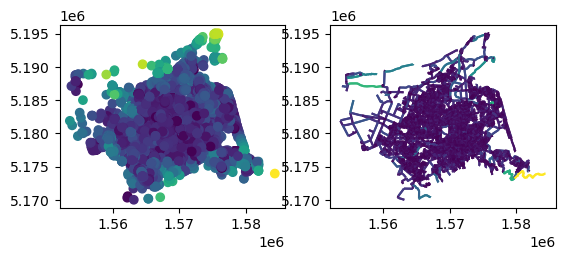

In [534]:
fig, (ax1, ax2) = plt.subplots(1,2)

gdf_nodes_schools.plot(ax=ax1, column=gdf_nodes_schools['travel_time'])
gdf_edges_schools.plot(ax=ax2, column=gdf_edges_schools['travel_time'])

## Hospitals

This analysis follows the exact same steps as the schools.

In [535]:
# adding x and y values to the geodataframe
hospitals_proj['x'] = hospitals_proj.geometry.centroid.x

hospitals_proj['y'] = hospitals_proj.geometry.centroid.y

In [536]:
hospitals_proj.head(3)

amenity healthcare                           name  \
element_type osmid                                                            
node         1225250003  hospital   hospital        Forensic Community Team   
             2740957987  hospital   hospital           St George's Hospital   
             2740957995  hospital   hospital  Rosewood Rest Home & Hospital   

                                                geometry     addr:city  \
element_type osmid                                                       
node         1225250003  POINT (1566826.669 5178170.593)           NaN   
             2740957987  POINT (1569157.134 5182404.584)  Christchurch   
             2740957995  POINT (1574191.942 5180793.479)  Christchurch   

                        addr:country addr:housenumber addr:postcode  \
element_type osmid                                                    
node         1225250003          NaN              NaN           NaN   
             2740957987           NZ              249          8140   
             2740957995           NZ              288          8062   

                          addr:street   wikidata  ... building  \
element_type osmid                                ...            
node         1225250003           NaN        NaN  ...      NaN   
             2740957987  Papanui Road  Q79596822  ...      NaN   
             2740957995  Woodham Road        NaN  ...      NaN   

                        building:levels phone roof:levels smoking email ways  \
element_type osmid                                                             
node         1225250003             NaN   NaN         NaN     NaN   NaN  NaN   
             2740957987             NaN   NaN         NaN     NaN   NaN  NaN   
             2740957995             NaN   NaN         NaN     NaN   NaN  NaN   

                        type             x             y  
element_type osmid                                        
node         1225250003  NaN  1.566827e+06  5.178171e+06  
             2740957987  NaN  1.569157e+06  5.182405e+06  
             2740957995  NaN  1.574192e+06  5.180793e+06  

[3 rows x 37 columns]

In [537]:
# finding the list of network nodes closest to each school
hospital_node_ids = ox.distance.nearest_nodes(graph_proj, hospitals_proj['x'], hospitals_proj['y'])

# ensuring all data is accounted for
len(hospital_node_ids) == len(hospitals_proj)

True

In [538]:
# Finding travel times for each node and hospital
hospitals, routes = nx.multi_source_dijkstra(graph_proj, hospital_node_ids, weight='travel_time')

# set travel_time in minutes as attribute to each network node
for node_id in hospitals:
    graph_proj.nodes.get(node_id)["travel_time"] = hospitals[node_id]/60

# get nodes and edges as Geo data frame
gdf_nodes_hospitals, gdf_edges_hospitals = ox.graph_to_gdfs(graph_proj)

# find longest travel time 
max_time_sec = max(travel_times.values())/60

In [539]:
gdf_nodes_hospitals.head()

y             x  street_count         lon        lat  \
osmid                                                                        
25365440   5.184738e+06  1.563152e+06             3  172.544295 -43.489374   
38436205   5.184788e+06  1.563169e+06             3  172.544510 -43.488923   
25365447   5.184745e+06  1.563180e+06             3  172.544638 -43.489315   
25365444   5.184692e+06  1.563173e+06             3  172.544545 -43.489786   
901606001  5.184692e+06  1.563169e+06             3  172.544494 -43.489785   

           travel_time highway                         geometry  
osmid                                                            
25365440      4.446667     NaN  POINT (1563152.322 5184737.893)  
38436205      4.510000     NaN  POINT (1563169.441 5184788.031)  
25365447      4.483333     NaN  POINT (1563180.061 5184744.564)  
25365444      4.368333     NaN  POINT (1563172.819 5184692.215)  
901606001     4.373333     NaN  POINT (1563168.727 5184692.326)

In [540]:
# frame statistics
gdf_nodes_hospitals['travel_time'].describe()

count    10908.000000
mean         3.980370
std          2.559551
min          0.000000
25%          2.166667
50%          3.428333
75%          5.344167
max         21.295000
Name: travel_time, dtype: float64

In [541]:
gdf_edges_hospitals['travel_time'].describe()

count    25374.000000
mean        11.072976
std         12.492547
min          0.100000
25%          4.500000
50%          8.100000
75%         13.800000
max        372.200000
Name: travel_time, dtype: float64

<Axes: >

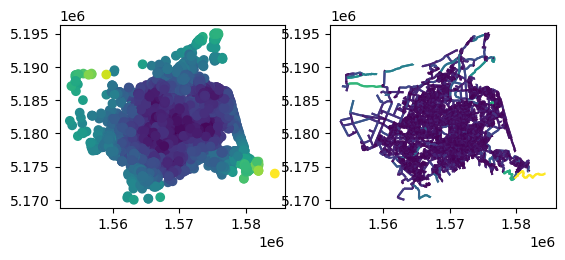

In [542]:
fig, (ax1, ax2) = plt.subplots(1,2)

gdf_nodes_hospitals.plot(ax=ax1, column=gdf_nodes_hospitals['travel_time'])
gdf_edges_hospitals.plot(ax=ax2, column=gdf_edges_hospitals['travel_time'])

## Supermarkets

In [543]:
# adding x and y values to the geodataframe
supermarkets_proj['x'] = supermarkets_proj.geometry.centroid.x

supermarkets_proj['y'] = supermarkets_proj.geometry.centroid.y

In [544]:
supermarkets_proj.head(3)

branch        brand brand:wikidata  \
element_type osmid                                                
node         469313826   Barrington  FreshChoice      Q22271877   
             1649789483      Hornby    PAK'nSAVE       Q7125339   
             1655359827         NaN          NaN            NaN   

                        brand:wikipedia                     name  \
element_type osmid                                                 
node         469313826   en:FreshChoice              FreshChoice   
             1649789483    en:Pak'nSave                PAK'nSAVE   
             1655359827             NaN  Big Chicken Supermarket   

                             opening_hours         shop wheelchair  \
element_type osmid                                                   
node         469313826   Mo-Su 07:00-22:00  supermarket        yes   
             1649789483  Mo-Su 07:00-23:00  supermarket        yes   
             1655359827  Sa-Su 07:30-19:00  supermarket        NaN   

                                                geometry     addr:city  ...  \
element_type osmid                                                      ...   
node         469313826   POINT (1569356.233 5177395.560)           NaN  ...   
             1649789483  POINT (1561478.810 5178795.626)  Christchurch  ...   
             1655359827  POINT (1566085.793 5179668.183)           NaN  ...   

                        payment:visa_debit payment:eftpos indoor construction  \
element_type osmid                                                              
node         469313826                 NaN            NaN    NaN          NaN   
             1649789483                NaN            NaN    NaN          NaN   
             1655359827                NaN            NaN    NaN          NaN   

                        email ways origin type             x             y  
element_type osmid                                                          
node         469313826    NaN  NaN    NaN  NaN  1.569356e+06  5.177396e+06  
             1649789483   NaN  NaN    NaN  NaN  1.561479e+06  5.178796e+06  
             1655359827   NaN  NaN    NaN  NaN  1.566086e+06  5.179668e+06  

[3 rows x 65 columns]

In [545]:
# finding the list of network nodes closest to each school
supermarket_node_ids = ox.distance.nearest_nodes(graph_proj, supermarkets_proj['x'], supermarkets_proj['y'])

# ensuring all data is accounted for
len(origin_node_ids) == len(supermarkets_proj)

False

In [546]:
# Finding travel times for each node and hospital
supermarkets, routes = nx.multi_source_dijkstra(graph_proj, supermarket_node_ids, weight='travel_time')

# set travel_time in minutes as attribute to each network node
for node_id in supermarkets:
    graph_proj.nodes.get(node_id)["travel_time"] = supermarkets[node_id]/60

# get nodes and edges as Geo data frame
gdf_nodes_supermarkets, gdf_edges_supermarkets = ox.graph_to_gdfs(graph_proj)

# find longest travel time 
max_time_sec = max(travel_times.values())/60

In [547]:
gdf_nodes_supermarkets.head()

y             x  street_count         lon        lat  \
osmid                                                                        
25365440   5.184738e+06  1.563152e+06             3  172.544295 -43.489374   
38436205   5.184788e+06  1.563169e+06             3  172.544510 -43.488923   
25365447   5.184745e+06  1.563180e+06             3  172.544638 -43.489315   
25365444   5.184692e+06  1.563173e+06             3  172.544545 -43.489786   
901606001  5.184692e+06  1.563169e+06             3  172.544494 -43.489785   

           travel_time highway                         geometry  
osmid                                                            
25365440      0.523333     NaN  POINT (1563152.322 5184737.893)  
38436205      0.586667     NaN  POINT (1563169.441 5184788.031)  
25365447      0.560000     NaN  POINT (1563180.061 5184744.564)  
25365444      0.445000     NaN  POINT (1563172.819 5184692.215)  
901606001     0.450000     NaN  POINT (1563168.727 5184692.326)

<Axes: >

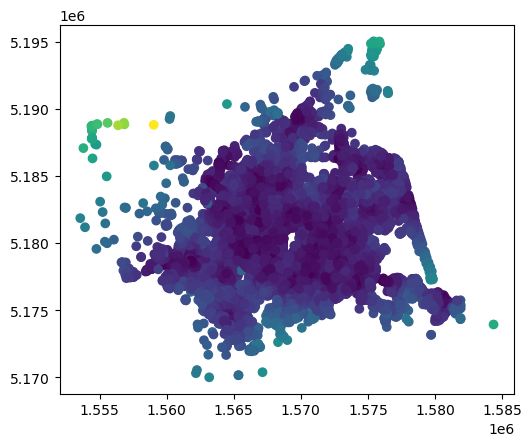

In [548]:
gdf_nodes_supermarkets.plot(column=gdf_nodes_supermarkets['travel_time'])

In [549]:
gdf_nodes_supermarkets.head()

y             x  street_count         lon        lat  \
osmid                                                                        
25365440   5.184738e+06  1.563152e+06             3  172.544295 -43.489374   
38436205   5.184788e+06  1.563169e+06             3  172.544510 -43.488923   
25365447   5.184745e+06  1.563180e+06             3  172.544638 -43.489315   
25365444   5.184692e+06  1.563173e+06             3  172.544545 -43.489786   
901606001  5.184692e+06  1.563169e+06             3  172.544494 -43.489785   

           travel_time highway                         geometry  
osmid                                                            
25365440      0.523333     NaN  POINT (1563152.322 5184737.893)  
38436205      0.586667     NaN  POINT (1563169.441 5184788.031)  
25365447      0.560000     NaN  POINT (1563180.061 5184744.564)  
25365444      0.445000     NaN  POINT (1563172.819 5184692.215)  
901606001     0.450000     NaN  POINT (1563168.727 5184692.326)

In [550]:
gdf_edges_supermarkets.head()

osmid  oneway  \
u        v          key                                                         
25365440 38436205   0                [1133615064, 5365476, 597540814]    True   
         25365447   0                                       488963306    True   
38436205 25365447   0                                        48246153    True   
         2682886711 0    [114220330, 113106934, 317875213, 692144366]   False   
25365447 901606056  0                                       837770558    True   

                        lanes                      name       highway  \
u        v          key                                                 
25365440 38436205   0       1                Durey Road  unclassified   
         25365447   0       2  Sister Cities Roundabout       primary   
38436205 25365447   0       2                Durey Road  unclassified   
         2682886711 0     NaN                Durey Road  unclassified   
25365447 901606056  0       2  Sister Cities Roundabout       primary   

                        reversed   length  \
u        v          key                     
25365440 38436205   0      False   53.048   
         25365447   0      False   29.956   
38436205 25365447   0      False   45.576   
         2682886711 0       True  326.442   
25365447 901606056  0      False    6.124   

                                                                  geometry  \
u        v          key                                                      
25365440 38436205   0    LINESTRING (1563152.322 5184737.893, 1563157.3...   
         25365447   0    LINESTRING (1563152.322 5184737.893, 1563156.1...   
38436205 25365447   0    LINESTRING (1563169.441 5184788.031, 1563171.5...   
         2682886711 0    LINESTRING (1563169.441 5184788.031, 1563169.6...   
25365447 901606056  0    LINESTRING (1563180.061 5184744.564, 1563184.0...   

                         speed_kph  travel_time  maxspeed    junction access  \
u        v          key                                                        
25365440 38436205   0         50.1          3.8       NaN         NaN    NaN   
         25365447   0         50.0          2.2        50  roundabout    NaN   
38436205 25365447   0         50.1          3.3       NaN         NaN    NaN   
         2682886711 0         20.0         58.8  [10, 30]         NaN     no   
25365447 901606056  0         50.0          0.4        50  roundabout    NaN   

                        bridge  ref width tunnel  
u        v          key                           
25365440 38436205   0      NaN  NaN   NaN    NaN  
         25365447   0      NaN  NaN   NaN    NaN  
38436205 25365447   0      NaN  NaN   NaN    NaN  
         2682886711 0      NaN  NaN   NaN    NaN  
25365447 901606056  0      NaN  NaN   NaN    NaN

In [551]:
# frame statistics
gdf_nodes_supermarkets['travel_time'].describe()

count    10908.000000
mean         1.843076
std          1.315315
min          0.000000
25%          0.951667
50%          1.585000
75%          2.455417
max         16.753333
Name: travel_time, dtype: float64

In [552]:
# frame statistics
gdf_edges_supermarkets['travel_time'].describe()

count    25374.000000
mean        11.072976
std         12.492547
min          0.100000
25%          4.500000
50%          8.100000
75%         13.800000
max        372.200000
Name: travel_time, dtype: float64

<Axes: >

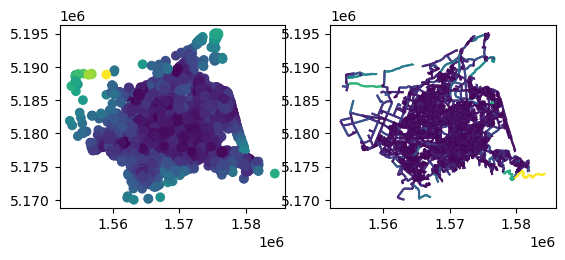

In [553]:
fig, (ax1, ax2) = plt.subplots(1,2)

gdf_nodes_supermarkets.plot(ax=ax1, column=gdf_nodes_supermarkets['travel_time'])
gdf_edges_supermarkets.plot(ax=ax2, column=gdf_edges_supermarkets['travel_time'])

## Summary Statistics and Maps

Text(0.5, 1.0, 'Schools')

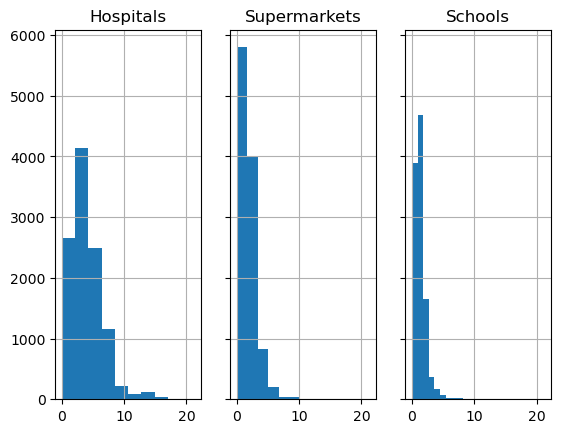

In [554]:
# generating a plot to show 
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, sharex=True)

gdf_nodes_hospitals['travel_time'].hist(ax=ax1, bins=10)
gdf_nodes_supermarkets['travel_time'].hist(ax=ax2, bins=10)
gdf_nodes_schools['travel_time'].hist(ax=ax3, bins=10)
ax1.set_title('Hospitals')
ax2.set_title('Supermarkets')
ax3.set_title('Schools')

Text(0.5, 1.0, 'Schools')

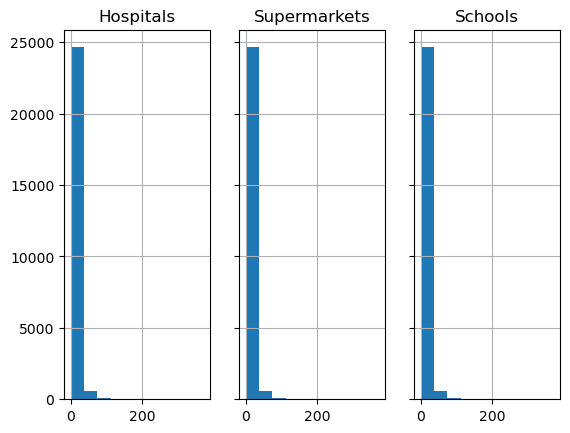

In [555]:
# generating a plot to show 
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, sharex=True)

gdf_edges_hospitals['travel_time'].hist(ax=ax1, bins=10)
gdf_edges_supermarkets['travel_time'].hist(ax=ax2, bins=10)
gdf_edges_schools['travel_time'].hist(ax=ax3, bins=10)
ax1.set_title('Hospitals')
ax2.set_title('Supermarkets')
ax3.set_title('Schools')

Text(0.5, 1.0, 'Hospitals')

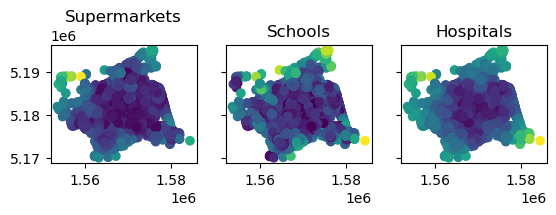

In [556]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, sharex=True)

gdf_nodes_supermarkets.plot(ax=ax1, column=gdf_nodes_supermarkets['travel_time'])
gdf_nodes_schools.plot(ax=ax2, column=gdf_nodes_schools['travel_time'])
gdf_nodes_hospitals.plot(ax=ax3, column=gdf_nodes_hospitals['travel_time'])

ax1.set_title('Supermarkets')
ax2.set_title('Schools')
ax3.set_title('Hospitals')

Text(0.5, 1.0, 'Hospitals')

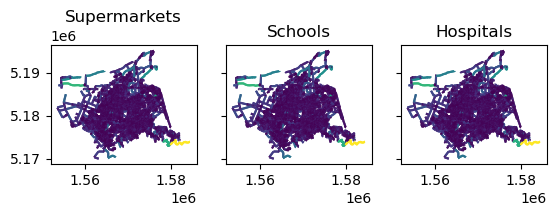

In [557]:
# Edges stay the same, as they are 

fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, sharex=True)

gdf_edges_supermarkets.plot(ax=ax1, column=gdf_edges_supermarkets['travel_time'])
gdf_edges_schools.plot(ax=ax2, column=gdf_edges_schools['travel_time'])
gdf_edges_hospitals.plot(ax=ax3, column=gdf_edges_hospitals['travel_time'])

ax1.set_title('Supermarkets')
ax2.set_title('Schools')
ax3.set_title('Hospitals')

Text(0.5, 1.0, 'Driving Time to Hospitals in Christchurch')

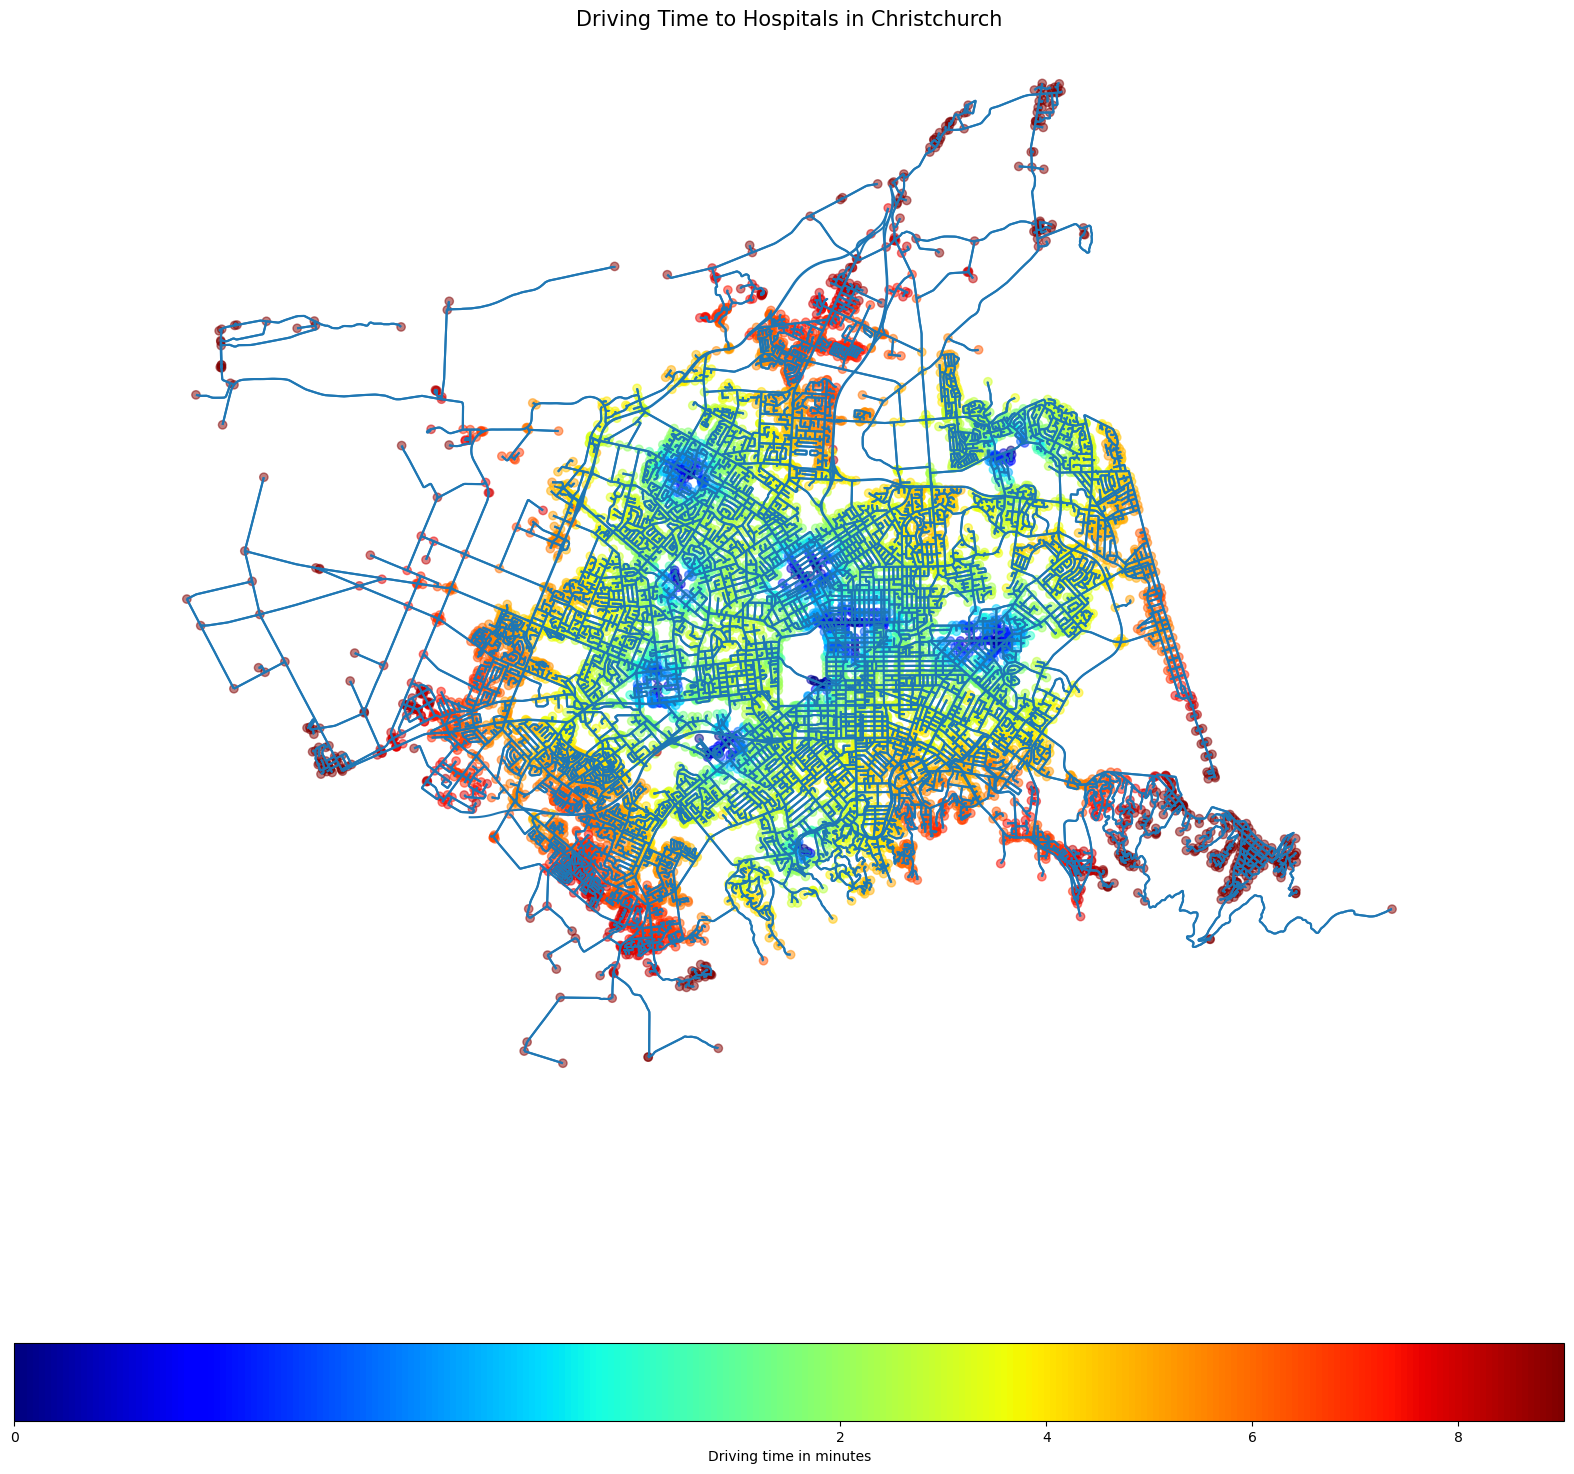

In [562]:
# Creating a heatmap of travel times

# define color scale using minimum and maximum travel times
norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=max_time_sec/6, vmax=max_time_sec)

fig = plt.figure(figsize=(20,20))
ax = plt.axes()
# hide x and y axis
ax.set_axis_off()

# add colotbat showing travel time and corresponding colour
cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap="jet"), 
    ax=ax, orientation='horizontal')

# plot each node with color indicating travel time
gdf_nodes_hospitals.plot(ax=ax, 
    column="travel_time", cmap="jet", norm=norm, alpha=.5)

gdf_edges.plot(ax=ax)
cb.set_label('Driving time in minutes', fontsize = 10)

ax.set_title('Driving Time to Hospitals in Christchurch', fontsize=15)

Text(0.5, 1.0, 'Driving Time to Supermarkets in Christchurch')

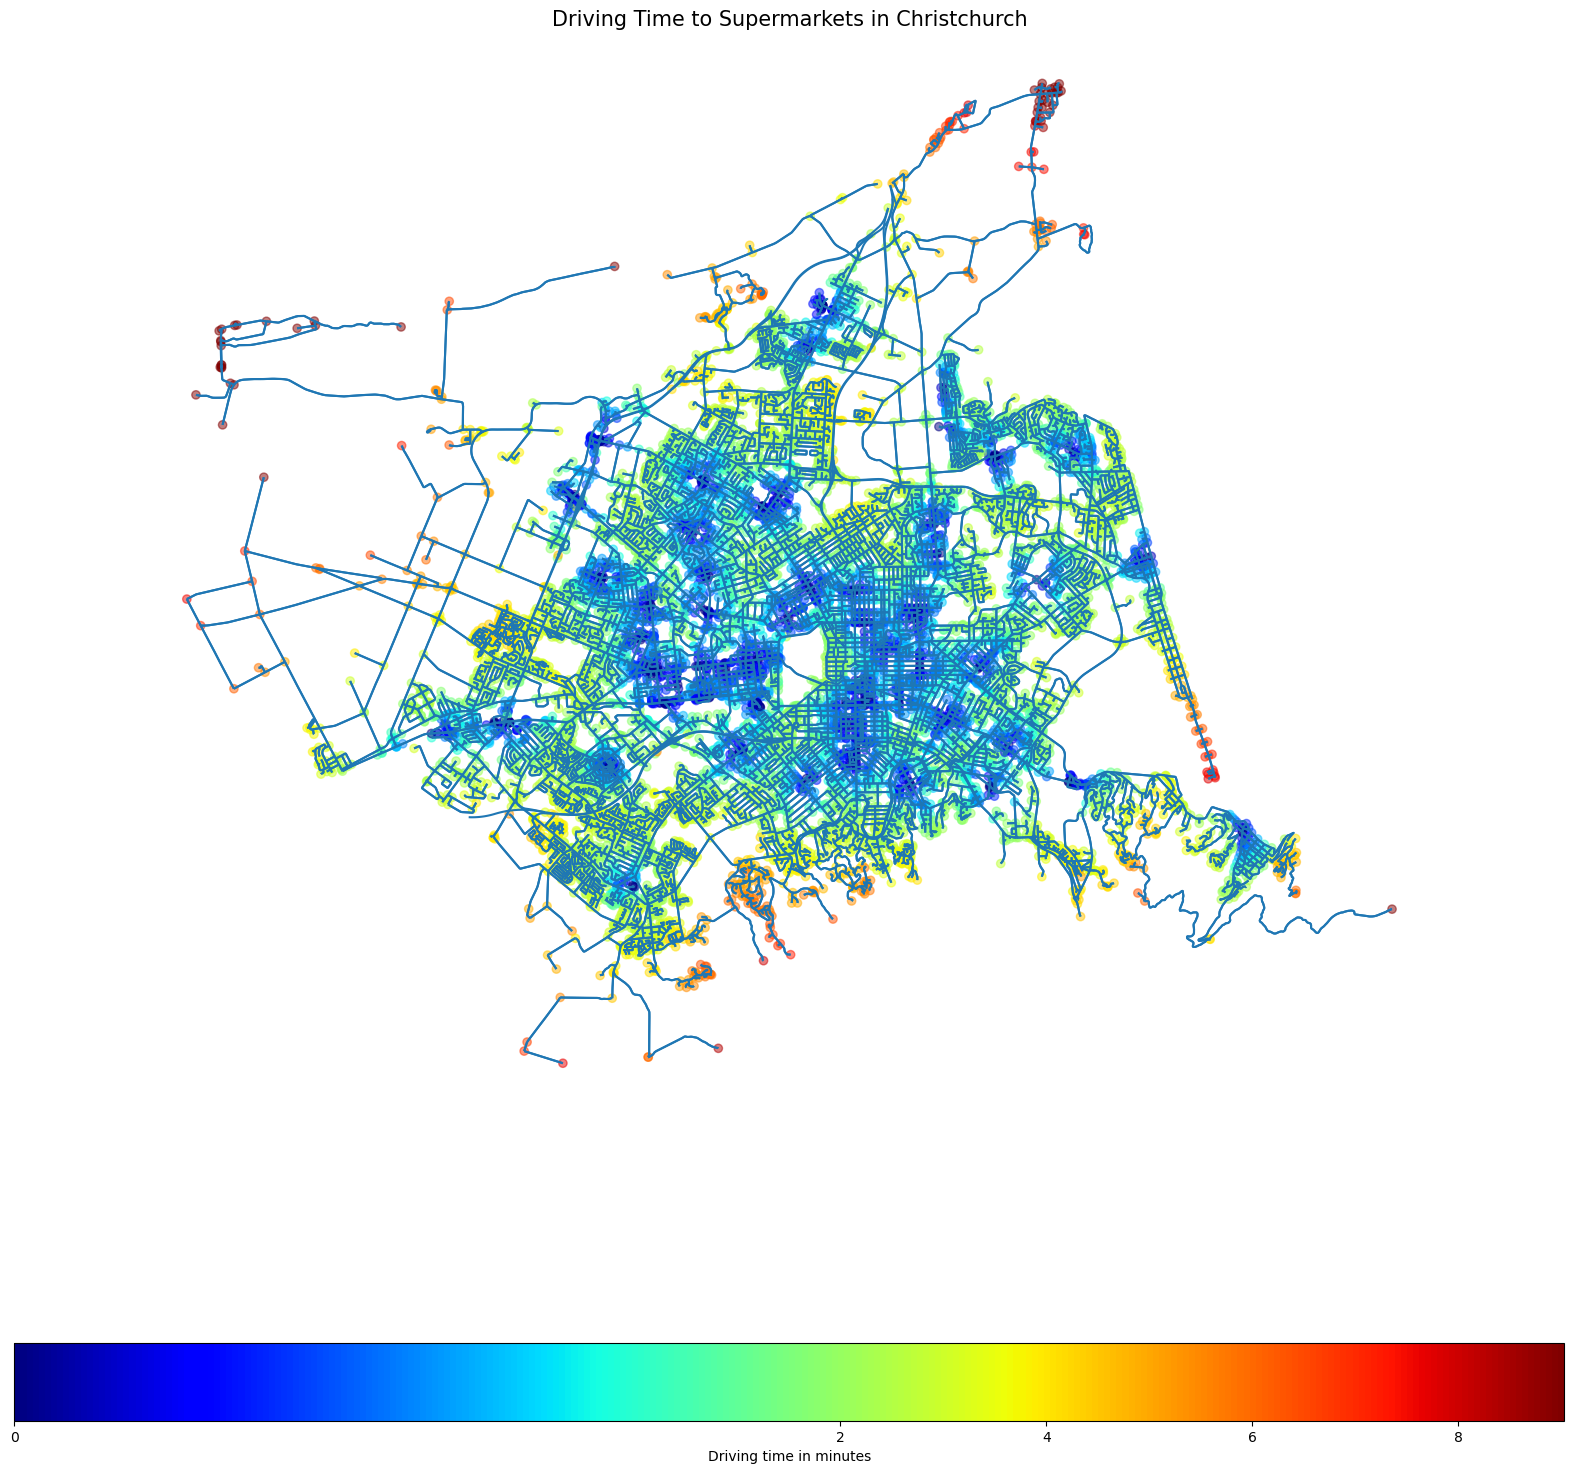

In [561]:
# Creating a heatmap of travel times

# define color scale using minimum and maximum travel times
norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=max_time_sec/6, vmax=max_time_sec)

fig = plt.figure(figsize=(20,20))
ax = plt.axes()
# hide x and y axis
ax.set_axis_off()

# add colotbat showing travel time and corresponding colour
cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap="jet"), 
    ax=ax, orientation='horizontal')

# plot each node with color indicating travel time
gdf_nodes_supermarkets.plot(ax=ax, 
    column="travel_time", cmap="jet", norm=norm, alpha=.5)

gdf_edges.plot(ax=ax)
cb.set_label('Driving time in minutes', fontsize = 10)

ax.set_title('Driving Time to Supermarkets in Christchurch', fontsize=15)

Text(0.5, 1.0, 'Driving Time to Schools in Christchurch')

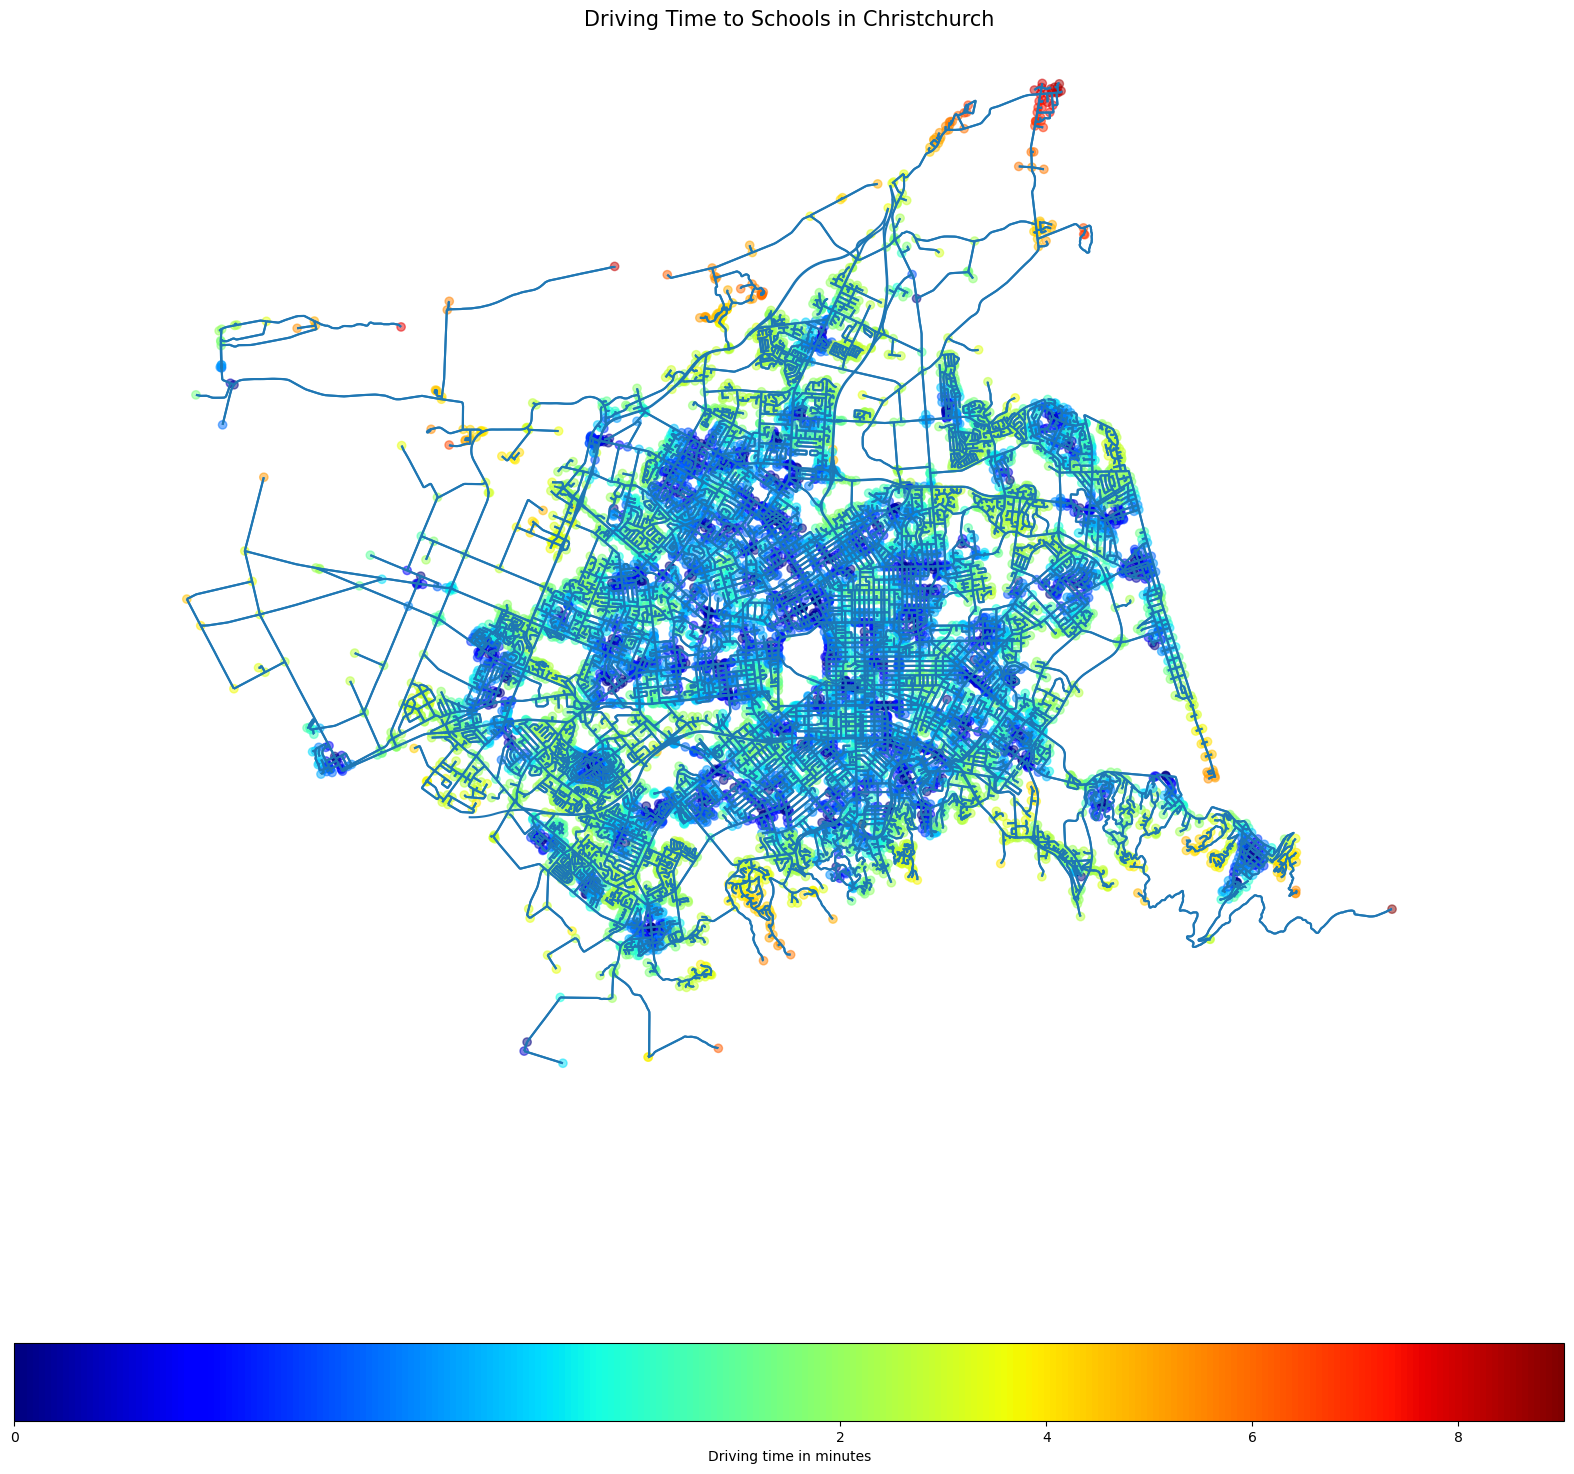

In [563]:
# Creating a heatmap of travel times

# define color scale using minimum and maximum travel times
norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=max_time_sec/6, vmax=max_time_sec)

fig = plt.figure(figsize=(20,20))
ax = plt.axes()
# hide x and y axis
ax.set_axis_off()

# add colotbat showing travel time and corresponding colour
cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap="jet"), 
    ax=ax, orientation='horizontal')

# plot each node with color indicating travel time
gdf_nodes_schools.plot(ax=ax, 
    column="travel_time", cmap="jet", norm=norm, alpha=.5)

gdf_edges.plot(ax=ax)
cb.set_label('Driving time in minutes', fontsize = 10)

ax.set_title('Driving Time to Schools in Christchurch', fontsize=15)